In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import Layer, InputSpec, Conv2D, DepthwiseConv2D, UpSampling2D, ZeroPadding2D, Lambda, AveragePooling2D, Input, Activation, Concatenate, Add, Reshape, BatchNormalization, Dropout 
from tensorflow.keras.utils import get_source_inputs
# from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__, end='\n\n')

2.1.0



In [2]:
# param
IMG_SIZE = 512
BATCH_SIZE = 8
OUTPUT_CHANNELS = 2
EPOCHS = 0
away_from_computer = True  # to show or not predictions between batches
save_model_for_inference = False # to save or not the model for inference

# WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"

# dataset location
Train_Images_Path = "D:/Python/DataSets/ADE20K_Filtered/Train/Images/0/"
Val_Images_Path =  "D:/Python/DataSets/ADE20K_Filtered/Validation/Images/0/"

In [3]:
# similar to glob but with tensorflow
train_imgs = tf.data.Dataset.list_files(Train_Images_Path + "*.jpg")
val_imgs = tf.data.Dataset.list_files(Val_Images_Path + "*.jpg")


@tf.function
def parse_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask_path = tf.strings.regex_replace(img_path, "Images", "Masks")
    mask_path = tf.strings.regex_replace(mask_path, ".jpg", "_seg.png")
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    
    return {'image': image, 'segmentation_mask' : mask}

train_set = train_imgs.map(parse_image)
test_set = val_imgs.map(parse_image)
dataset = {"train": train_set, "test": test_set}

print(dataset.keys())


# first create the function to normalize, resize and apply some data augmentation on the dataset:

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of IMG_SIZE [IMG_SIZE,IMG_SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of IMG_SIZE [IMG_SIZE,IMG_SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.uint8) / 255
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the test set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Then I set some parameters related to my dataset:

train_imgs = glob(Train_Images_Path + "*.jpg")
val_imgs = glob(Val_Images_Path + "*.jpg")
TRAIN_LENGTH = len(train_imgs)
VAL_LENGTH = len(val_imgs)
print('train lenght: ', TRAIN_LENGTH)
print('val lenght: ', VAL_LENGTH)


BUFFER_SIZE = BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
print('steps per epoch: ', STEPS_PER_EPOCH)

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

dict_keys(['train', 'test'])
train lenght:  4098
val lenght:  334
steps per epoch:  512


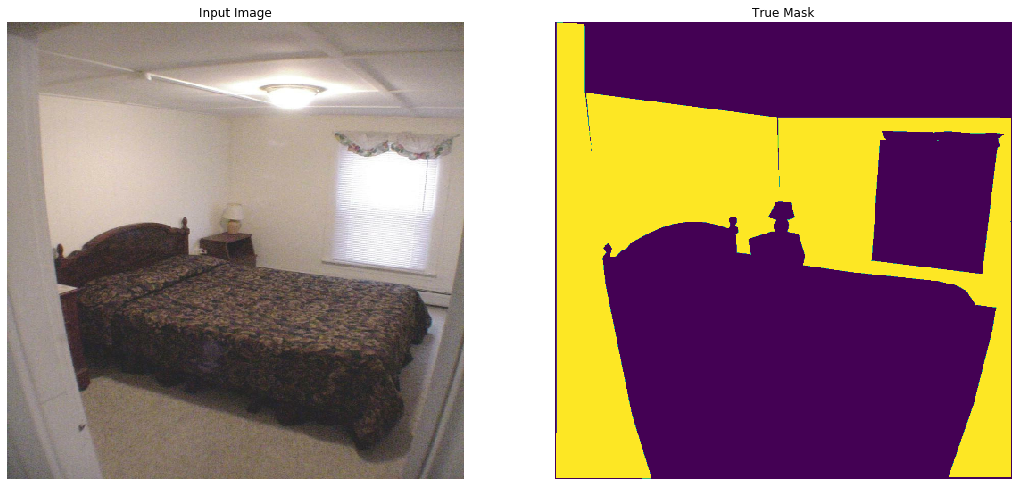

In [5]:
# Visualizing the Loaded Dataset

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    # print(sample_mask)

display_sample([sample_image, sample_mask])

# print('train daset: ', train)
